In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
sns.set_context("poster")
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def update_tf_name(df):
    # make TF name consistent across different datasets
    sgRNA_name_change = pd.read_csv('../External_data/gene_annotation/tf_name_change.txt', 
                        sep="\t", names = ['new','synonym'])
    name_change_dict = pd.Series(sgRNA_name_change.new.values, index=sgRNA_name_change.synonym).to_dict()
    rows_need_update = df['tf_gene'].isin(sgRNA_name_change.synonym)
    df.loc[rows_need_update,'tf_gene'] = df.loc[rows_need_update,'tf_gene'].map(name_change_dict)
    return df

# DAP-seq results (Baumgart et al., 2021)
def read_DAP_seq():
    file_name = '../External_data/DAP_operon.bed'
    column_name = ['site_start','site_end','tf_gene','FC_DAP','operon']
    DAP_df = pd.read_csv(file_name, sep="\t", names = column_name, usecols = [1, 2, 3, 6, 12])
    DAP_df['tf_gene'] = DAP_df['tf_gene'].str.extract(r"(^\S+?)_", expand=False)
    DAP_df = update_tf_name(DAP_df)
    num_binding_map = (DAP_df['tf_gene']+'_'+DAP_df['operon']).value_counts().to_dict()
    DAP_df['num_binding_site'] = (DAP_df['tf_gene']+'_'+DAP_df['operon']).map(num_binding_map)
    DAP_unique_df = DAP_df.sort_values(by = 'FC_DAP').drop_duplicates(subset=['tf_gene','operon'], keep='last')
    return DAP_unique_df

# TF protein expression level by Ribo-seq (Li et al., 2014)
def read_Ribo_seq():
    file_name = '../External_data/Li2014_minimal.txt'
    column_name = ['gene_name','expression_level','confidence']
    Protein_level_df = pd.read_csv(file_name, names = column_name, sep="\t", skiprows = 1)
    gene_to_expression_map = pd.Series(Protein_level_df.expression_level.values,index=Protein_level_df.gene_name).to_dict()
    return gene_to_expression_map

# Transcription start site (TSS) information
def read_TSS_map():
    file_name = '../External_data/gene_annotation/TSS_operon.bed'
    column_name = ['promoter_name','pos_1','operon','strand']
    TSS_df = pd.read_csv(file_name, sep="\t", names = column_name, usecols = [3, 6, 10, 12])
    # using the closest TSS to the start codon
    TSS_unique_df = pd.concat(
        [TSS_df[TSS_df['strand']=='+'].sort_values(by = 'pos_1').drop_duplicates(subset=['operon'], keep='last'),
         TSS_df[TSS_df['strand']=='-'].sort_values(by = 'pos_1').drop_duplicates(subset=['operon'], keep='first')])
    TSS_unique_df = TSS_unique_df.sort_values(by = 'pos_1').reset_index(drop = True)
    operon_to_TSS_map = pd.Series(TSS_unique_df.pos_1.values, index=TSS_unique_df.operon).to_dict()
    operon_to_strand_map = pd.Series(TSS_unique_df.strand.values, index=TSS_unique_df.operon).to_dict()
    return operon_to_TSS_map, operon_to_strand_map

def calculate_relative_distance_to_TSS(df):
    df['dist1'] = df['site_start'] - df['TSS']
    df['dist2'] = df['site_end'] - df['TSS']
    df['rel_pos'] = 0
    df.loc[(df['dist1']<0) & (df['dist2']<0),'rel_pos'] = df.loc[(df['dist1']<0) & (df['dist2']<0),'dist2']
    df.loc[(df['dist1']>0) & (df['dist2']>0),'rel_pos'] = df.loc[(df['dist1']>0) & (df['dist2']>0),'dist1']
    df.loc[df['operon_strand']=='-','rel_pos'] = - df.loc[df['operon_strand']=='-','rel_pos']
    return df['rel_pos']

In [3]:
PPTP_df = pd.read_csv('../Processed_data/PPTP_seq_DE_analysis.csv')
PPTP_df.rename(columns={'sgRNA': 'tf_gene'}, inplace=True)
PPTP_df = update_tf_name(PPTP_df)
DAP_df = read_DAP_seq()
operon_to_TSS_map, operon_to_strand_map = read_TSS_map()
gene_to_expression_map = read_Ribo_seq()

In [4]:
DAP_PPTP_intersect_df = pd.concat([PPTP_df.set_index(['tf_gene','operon']),
                                   DAP_df.set_index(['tf_gene','operon'])], 
                                 join = 'outer', axis = 1).reset_index()
DAP_PPTP_intersect_df = DAP_PPTP_intersect_df[DAP_PPTP_intersect_df['operon'].isin(PPTP_df['operon'].unique())]

DAP_PPTP_intersect_df['TSS'] = DAP_PPTP_intersect_df['operon'].map(operon_to_TSS_map)
DAP_PPTP_intersect_df['operon_strand'] = DAP_PPTP_intersect_df['operon'].map(operon_to_strand_map)
DAP_PPTP_intersect_df['tf_exp'] = DAP_PPTP_intersect_df['tf_gene'].map(gene_to_expression_map)
DAP_PPTP_intersect_df['rel_pos'] = calculate_relative_distance_to_TSS(DAP_PPTP_intersect_df)
DAP_PPTP_intersect_df['FC'] = DAP_PPTP_intersect_df['FC'].where(DAP_PPTP_intersect_df['std']<0.7)

In [5]:
binding_network = DAP_PPTP_intersect_df[(DAP_PPTP_intersect_df['FC_DAP']>5) 
                                        & (DAP_PPTP_intersect_df['FC'].notna()) 
                                        & (abs(DAP_PPTP_intersect_df['rel_pos'])<250) 
                                       ].reset_index(drop = True)
binding_site_df = pd.concat([binding_network.groupby('operon')['tf_gene'].count().rename('potential'),
                             binding_network[abs(binding_network['class'])==1].groupby('operon')['tf_gene'].count().rename('working')
                            ], axis=1).fillna(0)
binding_site_df.loc[binding_site_df['potential']>10,'potential']=11

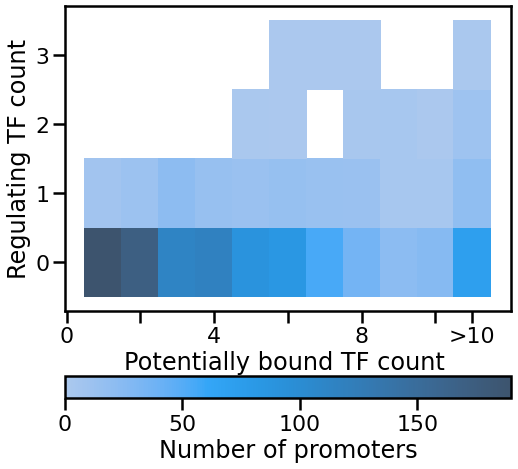

In [6]:
# Fig. 5b
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
sns.histplot(
    data=(binding_site_df), 
    x="potential", 
    y="working", 
    discrete=True,
    cbar=True,
    cbar_kws=dict(orientation='horizontal', label = 'Number of promoters'),
    ax = ax
)
ax.set(xlabel = 'Potentially bound TF count ', 
               ylabel = 'Regulating TF count',
#                yticks = [0,1,2,3], 
               xticks = [0,2,4,6,8,10,11], 
               xticklabels = [0,'',4,'',8,'','>10']);

In [7]:
binding_network['FC_DAP_norm_TF'] = binding_network['FC_DAP']/binding_network.groupby('tf_gene')['FC_DAP'].transform('max')
binding_network['FC_DAP_norm_promoter'] = binding_network['FC_DAP']/binding_network.groupby('operon')['FC_DAP'].transform('max')
binding_network.loc[binding_network['class']!=0,'regulating'] = 'Y'
binding_network.loc[binding_network['class']==0,'regulating'] = 'N'
binding_network['tf_exp_log10'] = np.log10(binding_network['tf_exp']+1)

[0.0, -16.0]
RanksumsResult(statistic=1.9323024361471677, pvalue=0.053322187920038046)
[2.1172712956557644, 2.2278867046136734]
RanksumsResult(statistic=2.2933783303991135, pvalue=0.021826233093420487)
[0.22470723146160992, 0.24922364451180773]
RanksumsResult(statistic=-0.025821714496894216, pvalue=0.9793995419583639)
[0.7369076557722258, 0.43095501080715704]
RanksumsResult(statistic=4.050809626746633, pvalue=5.104072171374874e-05)


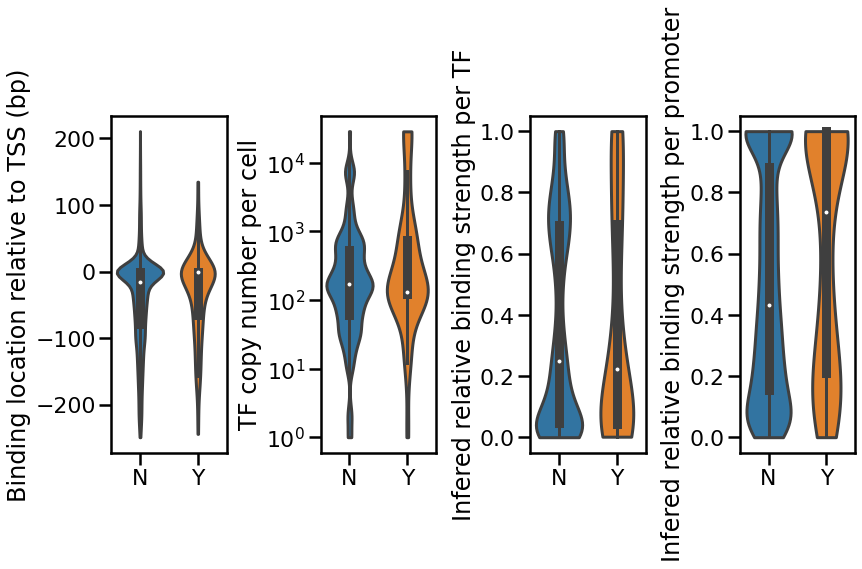

In [8]:
# Fig. 5c
fig, axes = plt.subplots(1,4, figsize=(12,6))
from matplotlib import ticker as mticker
fig.tight_layout()
col_list = ['rel_pos', 'tf_exp_log10', 'FC_DAP_norm_TF', 'FC_DAP_norm_promoter']
ylabel_list = ['Binding location relative to TSS (bp)', 'TF copy number per cell', 'Infered relative binding strength per TF', 'Infered relative binding strength per promoter']
for i in range(4):
    sns.violinplot(data = binding_network,
               x = 'regulating',
               y = col_list[i],
               cut=0,
               ax = axes[i]
              )
    axes[i].set(xlabel = '', ylabel = ylabel_list[i])
    result = ranksums(binding_network[binding_network['regulating']=='Y'][col_list[i]], 
         binding_network[binding_network['regulating']=='N'][col_list[i]])
    print([np.median(binding_network[binding_network['regulating']=='Y'][col_list[i]]), 
         np.median(binding_network[binding_network['regulating']=='N'][col_list[i]])])
    print(result)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))